# TikTok Virality Prediction Project

- **Juan López Segura**
- **Ignacio Urretavizcaya Tato**

This Jupyter Notebook details a project focused on separately analyzing audio, text, and video data extracted from 1,000 trending TikTok videos of 2020. The aim is to utilize these multimodal data inputs either by integrating them into multimodal models or by stacking models to predict the virality of TikTok videos.


## The Work

### Data Collection

A code has been created that, using a Github library, scrapes tiktok by downloading random videos from the trending tab and extracts all the main features. However, due to recent updates in security measures by TikTok, the collection was very slow, so an older and somewhat less rich data set has been chosen.

https://www.kaggle.com/datasets/erikvdven/tiktok-trending-december-2020

The data for this project is organized into separate folders based on the type of data:

**DATASET data**

- Audio data: `data/inputs/audio/`
- Text data: `data/inputs/text/`
- Video data: `data/inputs/videos/`

**PROCESSED data**

- Virality data: `data/inputs/virality_info.csv`

### Data Description

Each type of data includes elements specific to the medium:

- **Audio:** Includes the audio tracks from the videos, extracted through videos using ``src/utils`` functions

- **Text:** Consists of hashtags, video text descriptions, and transcriptions of the audio. The latter are extracted and explained in greater depth in the audio notebook.

- **Video:** Contains the video files themselves. For the analysis we will take 10 frames from each video.



## Purpose

The purpose of this analysis is to predict the virality of TikTok videos based on a defined metric of virality, which includes views, comments, likes, etc. By analyzing these metrics and their correlations, we can develop a predictive model.

### Virality Metric Definition

#### Data Loading and Study


In [17]:
import json
#load data/inputs/tiktok_info.json
with open('data/inputs/tiktok_info.json') as f:
    data = json.load(f)
    
#create a df with the id, lkikes, shares, comments and views
import pandas as pd
rows = []

# Iterar sobre el diccionario
for id, info in data.items():
    metrics = info["metrics"]
    # Crear un diccionario para cada fila
    row = {
        'id': id,
        'likes': metrics['likes'],
        'shares': metrics['shares'],
        'comments': metrics['comments'],
        'views': metrics['views']
    }
    # Agregar el diccionario a la lista de filas
    rows.append(row)

# Crear DataFrame
df = pd.DataFrame(rows)

In [18]:
df

,id,likes,shares,comments,views
0,6907228749016714497,3710,50,68,44800
1,6875468410612993286,55700,1817,936,838100
2,6898699405898059010,936200,21100,27100,15300000
3,6902819837345533186,12900,197,143,94900
4,6905635666588192002,8805,198,52,115300
...,...,...,...,...,...
995,6877191692341054721,13300,152,111,129300
996,6908069845825359109,12200,223,321,80700
997,6883484287434378497,26600,3392,668,449300
998,6898721943978036481,10000,111,274,72200


In [28]:
import matplotlib.pyplot as plt
import numpy as np

df_metrics = df[['likes', 'shares', 'comments', 'views']]
correlation_matrix = df_metrics.corr()
correlation_matrix

,likes,shares,comments,views
likes,1.000000,0.747000,0.965339,0.979589
shares,0.747000,1.000000,0.686832,0.773965
comments,0.965339,0.686832,1.000000,0.913404
views,0.979589,0.773965,0.913404,1.000000


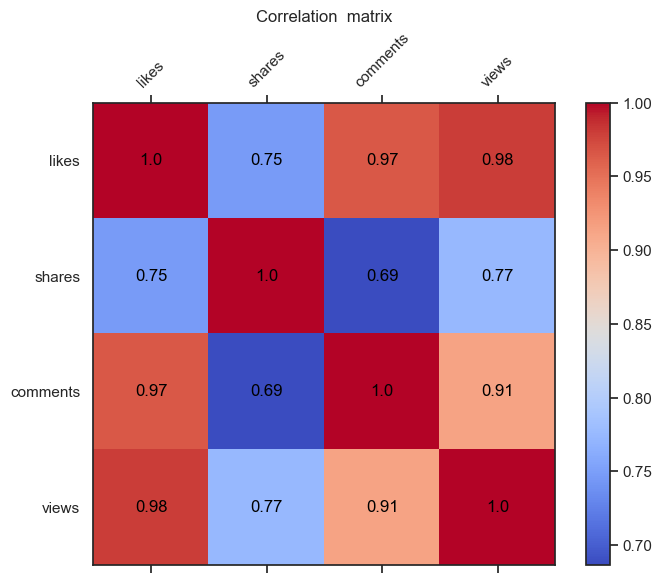

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(correlation_matrix, cmap='coolwarm')

fig.colorbar(cax)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.columns)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, round(correlation_matrix.iloc[i, j], 2),
                       ha="center", va="center", color="black")

plt.xticks(rotation=45)

ax.set_title('Correlation  matrix')

plt.show()

As can be seen from the correlation matrix, the number of views is extremely correlated with the number of comments and likes, displaying correlation coefficients of 0.98 and 0.91 respectively. This strong correlation suggests that as views increase, there is a significant tendency for both likes and comments to increase proportionally.

On the other hand, the number of shares, while still showing a relatively high correlation of 0.77, deviates slightly more compared to the other metrics. This indicates that shares are somewhat less predictably influenced by changes in views than likes and comments are.


Given the analysis, we have devised a method to calculate **virality** based primarily on the number of views, supplemented by the other metrics adjusted for their relative correlation strengths. The proposed formula for calculating virality is as follows:

$$
\text{Virality} = \text{views} + (1 - \text{corr}_{\text{views, likes}}) \times \text{likes} + (1 - \text{corr}_{\text{views, comments}}) \times \text{comments} + (1 - \text{corr}_{\text{views, shares}}) \times \text{shares}
$$

This approach aims to provide a more nuanced understanding of virality by weighting each factor according to its demonstrated influence on view count.


In [41]:
corrLikesFactor =  1 - correlation_matrix['views']['likes']
corrSharesFactor = 1 - correlation_matrix['views']['shares']
corrCommentsFactor = 1 - correlation_matrix['views']['comments']
df["virality"] = df["views"] + (df["likes"] * corrLikesFactor) + (df["shares"] * corrSharesFactor) + (df["comments"] * corrCommentsFactor)

#normalize the virality between 0 and 1
min_val = df['virality'].min()
max_val = df['virality'].max()

# Apply min-max normalization
df['norm_virality'] = (df['virality'] - min_val) / (max_val - min_val)


In [49]:
df

,id,likes,shares,comments,views,virality,norm_virality
0,6907228749016714497,3710,50,68,44800,4.489292e+04,0.000177
1,6875468410612993286,55700,1817,936,838100,8.397287e+05,0.003337
2,6898699405898059010,936200,21100,27100,15300000,1.532623e+07,0.060929
3,6902819837345533186,12900,197,143,94900,9.522022e+04,0.000377
4,6905635666588192002,8805,198,52,115300,1.155290e+05,0.000457
...,...,...,...,...,...,...,...
995,6877191692341054721,13300,152,111,129300,1.296154e+05,0.000513
996,6908069845825359109,12200,223,321,80700,8.102722e+04,0.000320
997,6883484287434378497,26600,3392,668,449300,4.506675e+05,0.001790
998,6898721943978036481,10000,111,274,72200,7.245293e+04,0.000286


In [52]:
#get the 3 highest norm_virality
df.nlargest(3, 'norm_virality')

,id,likes,shares,comments,views,virality,norm_virality
947,6894081763379924229,31000000,220100,625700,250800000,2.515367e+08,1.000000
706,6890571273110392065,5000000,110900,12200,68700000,6.882818e+07,0.273629
197,6900606242016840962,3500000,46600,23100,64500000,6.458397e+07,0.256756


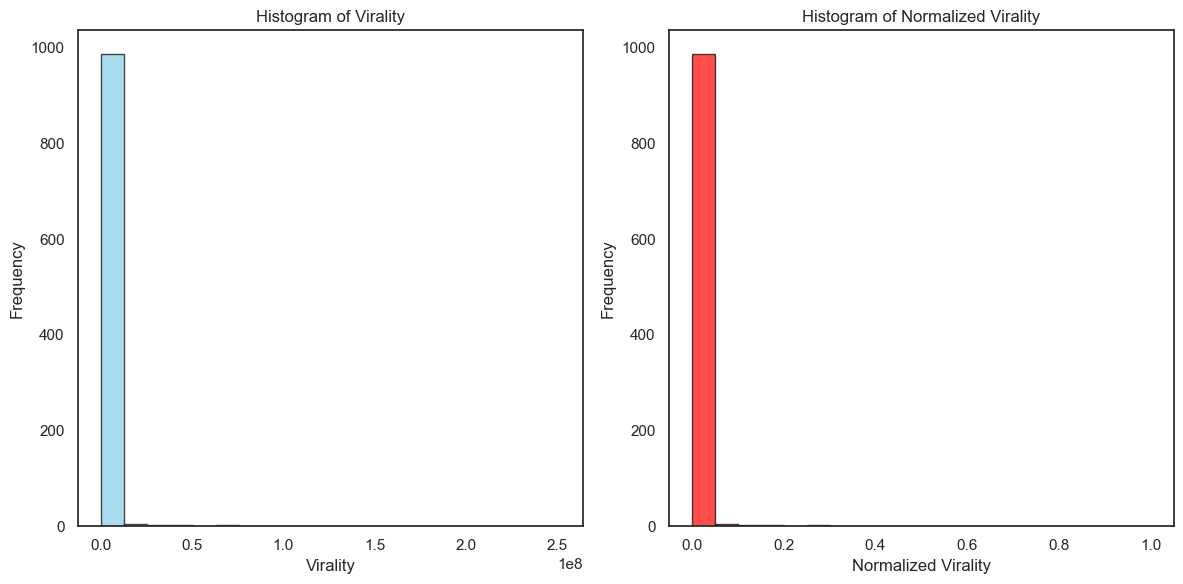

In [51]:
#histogram of virality and normalized virality
plt.figure(figsize=(12, 6))

# Histograma para 'virality'
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.hist(df['virality'], bins=20, color='skyblue', edgecolor="black", alpha=0.7)
plt.title('Histogram of Virality')
plt.xlabel('Virality')
plt.ylabel('Frequency')

# Histograma para 'normalized_virality'
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.hist(df['norm_virality'], bins=20, color='red', edgecolor="black", alpha=0.7)
plt.title('Histogram of Normalized Virality')
plt.xlabel('Normalized Virality')
plt.ylabel('Frequency')

# Mostrar el gráfico
plt.tight_layout()
plt.show()



Ideally, our DataFrame would include the number of followers at the time each video was posted, as this information could significantly enhance our understanding of the virality metrics. Unfortunately, this data is not currently available in our dataset. However, by utilizing our method of accessing the data through an API, we could potentially retrieve this crucial metric for a more rigorous analysis. Incorporating follower count would allow for a more nuanced assessment of virality by enabling us to calculate the ratio of views, comments, etc., per follower, which can provide a clearer picture of how viral a video truly is relative to the creator's existing audience.

From the histograms of virality and the percentile data from our DataFrame, it is evident that most virality scores are concentrated near zero, with the 75% percentile around 0.0008, suggesting that many videos achieve relatively low virality (in comparison to others in our dataset). However, there are outliers, such as the second highest normalized virality score at 0.2 and the highest at 1.0. These outliers indicate that while most content does not achieve high virality, a few videos become significantly viral. The number of followers would be especially useful here to adjust the virality score by followers, thus providing a scale to gauge how a video performs in terms of virality relative to the size of the uploader's audience.

While one could consider fetching the current number of followers for these accounts, this method has two main drawbacks:
 - The follower count could have changed significantly between the video posting date and today
 - The account itself might no longer exist.
 
Given these complications, our current approach does not incorporate follower data, but for future, more detailed studies, integrating real-time follower data through an API at the moment of video publication could yield more accurate insights into the dynamics of video virality.

In [54]:
#save the df to data/outputs/tiktok_info.csv
df.to_csv('data/inputs/virality_info.csv', index=False)

## Model Creation

For model creation, the initial approach involved individual models. Text, audio, and video cases were splitted, creating a thorough and personalized study for each. The respective notebooks delve much deeper into these cases (folders ``src/text``, ``src/audio``, ``src/image``), but the chosen results and models are as follows:

### Individual Models

#### Text

 + Model Selected: Roberta Transformer with custom layers & Fine-Tuning

 + Test MSE: 0.007877

 + Train - Valid MSE: 0.0006 - 0.0002

 + Model Name & Location: ``data/outputs/texts/best_model2.pth`` (Not uploaded due to its weight: over 1GB)

#### Audio

 + Model Selected: Custom 1D CNN + LSTM with Pooling, Dropout & Dense layers

 + Test MSE: 2.15746e-05

 + Train - Valid MSE: 3.1864e-04 - 1.1814e-04

 + Model Name & Location: ``data/outputs/audio/Audio_Final_Model.keras`` 

#### Image

### Multi-Modal Models

Following this, numerous avenues for result blending emerge:

 + Mean of the 3 models.

 + Weighted mean based on minimal error.
 
 + Stacking of the 3 models using a fourth (MLP, Transformer, etc.) to find the best combination of each. We want to make a mention of this method since, although it will not be implemented, it is very interesting. This is because, as mentioned, the models have a similar degree of precision but they are models with very different architectures from each other (a transformer, a one-dimensional CNN + LSTM and a two-dimensional CNN). Therefore, given that the sweet spot of stacking models is the mixture of good but very different models, it could be an interesting point of exploration.

 + Model of any type (SVM, XGBoost, MLP, Transformers, etc.) utilizing features extracted from each data type rather than the data itself.

 + Multimodal model incorporating data from all types.

In this case, due to the already exhaustive exploration of each model separately, only a multimodal model is developed, seeking a final improvement in precision.